In [2]:
import pandas as pd
import numpy as np
import lightgbm as lgb
from lightgbm import early_stopping, log_evaluation, LGBMRegressor
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore", message="No further splits with positive gain")

In [3]:
df = pd.read_csv("./data/claims_data.csv")

In [4]:
# Define categorical feature names (cat1 to cat116)
categorical_features = [f'cat{i}' for i in range(1, 117)]

# Define continuous feature names (cont1 to cont14)
continuous_features = [f'cont{i}' for i in range(1, 15)]

# Combine all features
all_features = categorical_features + continuous_features

print(f"Total features: {len(all_features)}")
print(f"Categorical features: {len(categorical_features)}")
print(f"Continuous features: {len(continuous_features)}")

Total features: 130
Categorical features: 116
Continuous features: 14


In [5]:
# Label encode all categorical features
label_encoders = {}

for col in categorical_features:
    le = LabelEncoder()
    # Fit the encoder and transform the data
    df[col] = le.fit_transform(df[col].astype(str))
    label_encoders[col] = le

print("Categorical features encoded successfully")
print(f"Sample of encoded data:\n{df[categorical_features[:3]].head()}")

Categorical features encoded successfully
Sample of encoded data:
   cat1  cat2  cat3
0     0     1     0
1     0     1     0
2     0     1     0
3     1     1     0
4     0     1     0


In [6]:
X = df[all_features]
y = np.log1p(df['loss'])  # Log transformation to handle skewed distribution

X_train, X_valid, y_train, y_valid = train_test_split(
    X, y,
    test_size=0.2,
    random_state=42  
)

print(f"Training set size: {X_train.shape}")
print(f"Validation set size: {X_valid.shape}")
print(f"Target variable (log-transformed) range: [{y_train.min():.2f}, {y_train.max():.2f}]")

Training set size: (150654, 130)
Validation set size: (37664, 130)
Target variable (log-transformed) range: [0.51, 11.70]


In [7]:
# Create LightGBM datasets with categorical feature specification
train_data = lgb.Dataset(
    X_train,
    label=y_train,
    categorical_feature=categorical_features
)
valid_data = lgb.Dataset(
    X_valid,
    label=y_valid,
    categorical_feature=categorical_features,
    reference=train_data  
)

params = {
    'objective': 'regression',      
    'metric': 'mae',                
    'boosting_type': 'gbdt',        
    'num_leaves': 31,               
    'learning_rate': 0.05,          
    'feature_fraction': 0.9,        
    'bagging_fraction': 0.8,        
    'bagging_freq': 5,              
    'verbose': -1                   
}

print("Training initial model with all features...")
model = lgb.train(
    params,
    train_data,
    num_boost_round=1000,           
    valid_sets=[train_data, valid_data],
    valid_names=['train', 'valid'],
    callbacks=[
        early_stopping(stopping_rounds=50),  
        log_evaluation(period=100)           
    ]
)

print(f"\nBest iteration: {model.best_iteration}")
print(f"Best validation MAE: {model.best_score['valid']['l1']:.4f}")

Training initial model with all features...
Training until validation scores don't improve for 50 rounds
[100]	train's l1: 0.42106	valid's l1: 0.425299
[200]	train's l1: 0.407299	valid's l1: 0.418162
[300]	train's l1: 0.400994	valid's l1: 0.417206
[400]	train's l1: 0.39643	valid's l1: 0.416954
[500]	train's l1: 0.392533	valid's l1: 0.416943
Early stopping, best iteration is:
[465]	train's l1: 0.393926	valid's l1: 0.416886

Best iteration: 465
Best validation MAE: 0.4169


In [8]:
# Make predictions on validation set
y_pred_log = model.predict(X_valid, num_iteration=model.best_iteration)

# Convert predictions back to original scale
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)

# Calculate Mean Absolute Error on original scale
mae = mean_absolute_error(y_true, y_pred)
print(f"Validation MAE (original scale): ${mae:,.2f}")

# Calculate Mean Absolute Percentage Error
mape = np.mean(np.abs((y_true - y_pred) / y_true)) * 100
print(f"Mean Absolute Percentage Error: {mape:.2f}%")

Validation MAE (original scale): $1,145.31
Mean Absolute Percentage Error: 47.98%


In [17]:
# Extract feature importances
importances = model.feature_importance(importance_type='gain')
feature_names = X_train.columns

# Create a DataFrame for easier analysis
feature_importance_df = pd.DataFrame({
    'feature': feature_names,
    'importance': importances
}).sort_values('importance', ascending=False)

# Test different numbers of top features
feature_counts = [5, 10, 15, 20, 25, 30, 40, 50, 75, 100, 130]
results = []

for n_features in feature_counts:
    # Get top N features
    top_n_features = feature_importance_df.head(n_features)['feature'].tolist()
    X_train_topn = X_train[top_n_features]
    X_valid_topn = X_valid[top_n_features]
    
    # Identify categorical features in this subset
    categorical_topn = [f for f in top_n_features if f in categorical_features]
    
    # Train model with consistent parameters
    model_topn = LGBMRegressor(
        objective='regression',
        n_estimators=1000,
        learning_rate=0.05,
        num_leaves=31,
        feature_fraction=0.9,
        bagging_fraction=0.8,
        bagging_freq=5,
        random_state=42,
        verbose=-1
    )
    
    model_topn.fit(
        X_train_topn, y_train,
        eval_set=[(X_valid_topn, y_valid)],
        eval_metric='mae',
        categorical_feature=categorical_topn,
        callbacks=[
            early_stopping(stopping_rounds=50, verbose=False)
        ]
    )
    
    # Evaluate
    y_pred_log = model_topn.predict(X_valid_topn)
    y_pred = np.expm1(y_pred_log)
    y_true = np.expm1(y_valid)
    mae = mean_absolute_error(y_true, y_pred)
    
    # Calculate metrics
    diff_from_full = mae - mean_absolute_error(np.expm1(y_valid), np.expm1(model.predict(X_valid)))
    pct_of_full = (n_features / len(all_features)) * 100
    
    results.append({
        'Features': n_features,
        'MAE': mae,
        'Diff_from_Full': diff_from_full,
        '% of Features': pct_of_full,
        'Best_Iteration': model_topn.best_iteration_
    })

# Create results DataFrame
results_df = pd.DataFrame(results)
print(f"{'Features':<10} {'% of Total':<12} {'MAE':<15} {'vs Full Model':<15} {'Best Iter':<12}")
print("-"*90)

for _, row in results_df.iterrows():
    print(f"{row['Features']:<10} {row['% of Features']:<11.1f}% "
          f"${row['MAE']:>10,.2f}    ${row['Diff_from_Full']:>+10,.2f}      "
          f"{row['Best_Iteration']:<12.0f}")

Features   % of Total   MAE             vs Full Model   Best Iter   
------------------------------------------------------------------------------------------
5.0        3.8        % $  1,371.87    $   +226.55      174         
10.0       7.7        % $  1,262.21    $   +116.90      230         
15.0       11.5       % $  1,179.24    $    +33.93      232         
20.0       15.4       % $  1,168.17    $    +22.86      239         
25.0       19.2       % $  1,164.45    $    +19.13      305         
30.0       23.1       % $  1,154.56    $     +9.25      305         
40.0       30.8       % $  1,152.30    $     +6.98      336         
50.0       38.5       % $  1,149.57    $     +4.25      305         
75.0       57.7       % $  1,147.45    $     +2.14      310         
100.0      76.9       % $  1,146.00    $     +0.69      343         
130.0      100.0      % $  1,146.58    $     +1.26      344         



BEST PERFORMANCE:
   Features: 100 (76.9% of total)
   MAE: $1,146.00
   Difference from full model: $+0.69

MOST EFFICIENT (within 1% of best):
   Features: 30 (23.1% of total)
   MAE: $1,154.56
   Difference from best: $+8.56


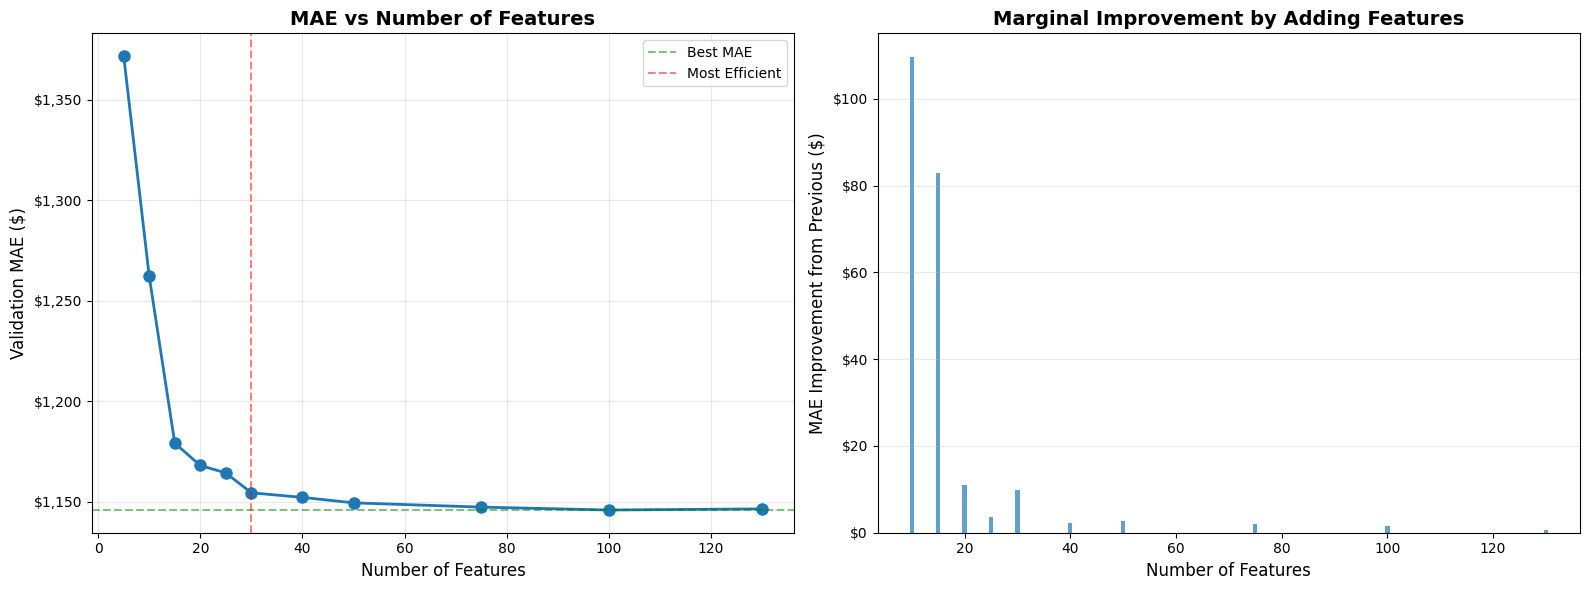

In [11]:
# Find optimal feature count (best MAE)
best_idx = results_df['MAE'].idxmin()
best_row = results_df.iloc[best_idx]

print(f"\nBEST PERFORMANCE:")
print(f"   Features: {best_row['Features']:.0f} ({best_row['% of Features']:.1f}% of total)")
print(f"   MAE: ${best_row['MAE']:,.2f}")
print(f"   Difference from full model: ${best_row['Diff_from_Full']:+,.2f}")

# Find elbow point (best efficiency - least features for <1% worse than best)
threshold = best_row['MAE'] * 1.01  # Within 1% of best
efficient = results_df[results_df['MAE'] <= threshold]
most_efficient = efficient.iloc[0]  # First one that meets threshold

print(f"\nMOST EFFICIENT (within 1% of best):")
print(f"   Features: {most_efficient['Features']:.0f} ({most_efficient['% of Features']:.1f}% of total)")
print(f"   MAE: ${most_efficient['MAE']:,.2f}")
print(f"   Difference from best: ${most_efficient['MAE'] - best_row['MAE']:+,.2f}")

# Visualization
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 6))

# Plot 1: MAE vs Number of Features
ax1.plot(results_df['Features'], results_df['MAE'], 'o-', linewidth=2, markersize=8)
ax1.axhline(y=best_row['MAE'], color='green', linestyle='--', alpha=0.5, label='Best MAE')
ax1.axvline(x=most_efficient['Features'], color='red', linestyle='--', alpha=0.5, label='Most Efficient')
ax1.set_xlabel('Number of Features', fontsize=12)
ax1.set_ylabel('Validation MAE ($)', fontsize=12)
ax1.set_title('MAE vs Number of Features', fontsize=14, fontweight='bold')
ax1.grid(True, alpha=0.3)
ax1.legend()

# Format y-axis as currency
ax1.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

# Plot 2: Marginal gain from adding features
marginal_gains = results_df['MAE'].diff().abs()
ax2.bar(results_df['Features'][1:], marginal_gains[1:], alpha=0.7)
ax2.set_xlabel('Number of Features', fontsize=12)
ax2.set_ylabel('MAE Improvement from Previous ($)', fontsize=12)
ax2.set_title('Marginal Improvement by Adding Features', fontsize=14, fontweight='bold')
ax2.grid(True, alpha=0.3, axis='y')
ax2.yaxis.set_major_formatter(plt.FuncFormatter(lambda x, p: f'${x:,.0f}'))

plt.tight_layout()
plt.show()

# Save optimal features
optimal_features = feature_importance_df.head(int(most_efficient['Features']))['feature'].tolist()

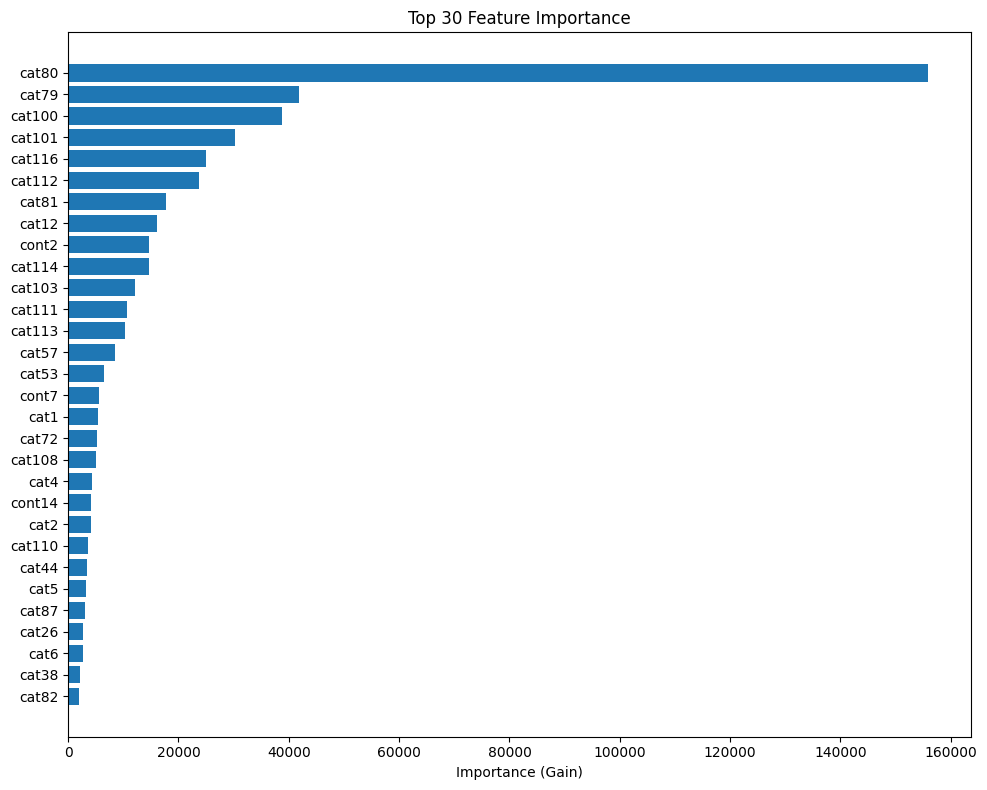

In [13]:
# Plot top 30 feature importance
plt.figure(figsize=(10, 8))
top_30 = feature_importance_df.head(30)
plt.barh(range(len(top_30)), top_30['importance'])
plt.yticks(range(len(top_30)), top_30['feature'])
plt.xlabel('Importance (Gain)')
plt.title('Top 30 Feature Importance')
plt.gca().invert_yaxis()
plt.tight_layout()
plt.show()

# Save top features
top_30_features = feature_importance_df.head(30)['feature'].tolist()

In [14]:
# Test top 30 with your BEST grid search params from top 20
optimized_params = {
    'objective': 'regression',
    'n_estimators': 1000,
    'learning_rate': 0.03,
    'num_leaves': 50,
    'max_depth': 10,
    'feature_fraction': 0.8,
    'bagging_fraction': 0.8,
    'lambda_l1': 0.1,
    'lambda_l2': 0,
    'random_state': 42
}

top_30_features = feature_importance_df.head(30)['feature'].tolist()
X_train_top30 = X_train[top_30_features]
X_valid_top30 = X_valid[top_30_features]
categorical_features_top30 = [f for f in top_30_features if f in categorical_features]

model_top30_quick = LGBMRegressor(**optimized_params)
model_top30_quick.fit(
    X_train_top30, y_train,
    eval_set=[(X_valid_top30, y_valid)],
    eval_metric='mae',
    categorical_feature=categorical_features_top30,
    callbacks=[early_stopping(stopping_rounds=50, verbose=False)]
)

y_pred_log = model_top30_quick.predict(X_valid_top30)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_valid)
mae_quick = mean_absolute_error(y_true, y_pred)

print(f"Top 30 with optimized params: ${mae_quick:,.2f}")

Top 30 with optimized params: $1,151.55


In [16]:
# Define parameter grid
param_grid_top30 = {
    'num_leaves': [31, 50],           
    'max_depth': [5, 10],             
    'learning_rate': [0.05, 0.03],    
    'feature_fraction': [0.8, 0.9],   
    'bagging_fraction': [0.8, 0.9],   
    'lambda_l1': [0, 0.1],            
    'lambda_l2': [0, 0.1]             
}

base_model = LGBMRegressor(
    objective='regression',
    n_estimators=1000,
    random_state=42,
    verbose=-1
)

grid_search_top30 = GridSearchCV(
    estimator=base_model,
    param_grid=param_grid_top30,
    scoring='neg_mean_absolute_error',
    cv=3,
    verbose=2,
    n_jobs=-1
)

grid_search_top30.fit(
    X_train_top30, y_train,
    eval_set=[(X_valid_top30, y_valid)],
    eval_metric='mae',
    categorical_feature=categorical_features_top30,
    callbacks=[lgb.early_stopping(stopping_rounds=50)]
)

Fitting 3 folds for each of 128 candidates, totalling 384 fits
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[423]	valid_0's l1: 0.423551	valid_0's l2: 0.297362
[CV] END bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=0, lambda_l2=0, learning_rate=0.05, max_depth=5, num_leaves=31; total time=  13.8s
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[202]	valid_0's l1: 0.422619	valid_0's l2: 0.296346
[CV] END bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=0, lambda_l2=0, learning_rate=0.05, max_depth=10, num_leaves=50; total time=  15.1s
Training until validation scores don't improve for 50 rounds
Early stopping, best iteration is:
[541]	valid_0's l1: 0.422267	valid_0's l2: 0.296117
[CV] END bagging_fraction=0.8, feature_fraction=0.8, lambda_l1=0, lambda_l2=0, learning_rate=0.03, max_depth=10, num_leaves=31; total time=  23.0s
Training until validation scores don't improve for 50

,estimator,LGBMRegressor... verbose=-1)
,param_grid,"{'bagging_fraction': [0.8, 0.9], 'feature_fraction': [0.8, 0.9], 'lambda_l1': [0, 0.1], 'lambda_l2': [0, 0.1], ...}"
,scoring,'neg_mean_absolute_error'
,n_jobs,-1
,refit,True
,cv,3
,verbose,2
,pre_dispatch,'2*n_jobs'
,error_score,nan
,return_train_score,False
,boosting_type,'gbdt'


In [18]:
for param, value in grid_search_top30.best_params_.items():
    print(f"  {param}: {value}")

best_cv_mae_log = -grid_search_top30.best_score_
print(f"\nBest cross-validation MAE (log scale): {best_cv_mae_log:.4f}")
print(f"Best cross-validation MAE (approx $): ${np.expm1(best_cv_mae_log):,.2f}")

best_model_top30 = grid_search_top30.best_estimator_

best_model_top30.fit(
    X_train_top30, y_train,
    eval_set=[(X_train_top30, y_train), (X_valid_top30, y_valid)],
    eval_names=['train', 'valid'],
    eval_metric='mae',
    categorical_feature=categorical_features_top30,
    callbacks=[
        early_stopping(stopping_rounds=50, verbose=False),
        log_evaluation(period=100)
    ]
)

y_pred_log_final = best_model_top30.predict(X_valid_top30)
y_pred_final = np.expm1(y_pred_log_final)
y_true = np.expm1(y_valid)

mae_final = mean_absolute_error(y_true, y_pred_final)
mape_final = np.mean(np.abs((y_true - y_pred_final) / y_true)) * 100

print(f"Validation MAE: ${mae_final:,.2f}")
print(f"MAPE: {mape_final:.2f}%")
print(f"Best iteration: {best_model_top30.best_iteration_}")

  bagging_fraction: 0.8
  feature_fraction: 0.8
  lambda_l1: 0.1
  lambda_l2: 0
  learning_rate: 0.03
  max_depth: 10
  num_leaves: 50

Best cross-validation MAE (log scale): 0.4242
Best cross-validation MAE (approx $): $0.53
[100]	train's l1: 0.433432	train's l2: 0.308311	valid's l1: 0.437266	valid's l2: 0.312073
[200]	train's l1: 0.413023	train's l2: 0.284452	valid's l1: 0.423079	valid's l2: 0.296707
[300]	train's l1: 0.405429	train's l2: 0.274928	valid's l1: 0.420991	valid's l2: 0.294418
[400]	train's l1: 0.400549	train's l2: 0.268561	valid's l1: 0.420527	valid's l2: 0.293931
[500]	train's l1: 0.396736	train's l2: 0.263524	valid's l1: 0.420372	valid's l2: 0.293742
Validation MAE: $1,151.55
MAPE: 48.66%
Best iteration: 502
